In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

### Filtrar imágenes corruptas
Cuando se trabaja con muchos datos de imágenes del mundo real, las imágenes dañadas son una ocurrencia común. Filtremos las imágenes mal codificadas que no tengan la cadena "JFIF" en su encabezado.

In [ ]:
# Filtrar imagenes corruptas 
import os

num_skipped = 0 # Numero de imagenes corruptas
for folder_name in ('Cat', 'Dog'): # Recorrer las carpetas
    folder_path = os.path.join('data/PetImages', folder_name) # Ruta de la carpeta
    for fname in os.listdir(folder_path): # Recorrer las imagenes
        fpath = os.path.join(folder_path, fname) # Ruta de la imagen
        try:
            fobj = open(fpath, 'rb') # Abrir la imagen
            is_jfif = tf.compat.as_bytes('JFIF') in fobj.peek(10) # Verificar si es jpeg
        finally:
            fobj.close() # Cerrar la imagen

        if not is_jfif: # Si no es jpeg
            num_skipped += 1 # Aumentar el numero de imagenes corruptas
            os.remove(fpath) # Eliminar la imagen

print('Numero de imagenes corruptas eliminadas:', num_skipped) # Imprimir el numero de imagenes corruptas

### Generar un Dataset

In [2]:
image_size = (128, 128) # Tamaño de las imagenes a utilizar en el clasificador 
batch_size = 32 # Tamaño del lote 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/PetImages',
    validation_split=0.2,
    subset='training',
    seed=123,
    image_size=image_size,
    batch_size=batch_size) # Dataset de entrenamiento

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    'data/PetImages',
    validation_split=0.2,
    subset='validation',
    seed=123,
    image_size=image_size,
    batch_size=batch_size) # Dataset de validacion

Found 23422 files belonging to 2 classes.
Using 18738 files for training.
Found 23422 files belonging to 2 classes.
Using 4684 files for validation.


### Visualizacion de los datos
Aquí están las primeras 9 imágenes en el conjunto de datos de entrenamiento. Como puede ver, la etiqueta 1 es "perro" y la etiqueta 0 es "gato".

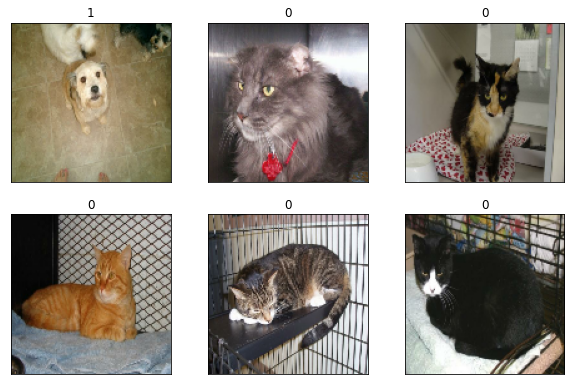

In [4]:
# Visualizar los datos

plt.figure(figsize=(10, 10)) # Crear una figura de 10x10

for i, (imagen, label) in enumerate(train_ds.take(6)): # Recorrer las imagenes
    imagen = imagen.numpy().astype('uint8') # Convertir a numpy
    plt.subplot(3, 3, i + 1) # Subplote de 3x3
    plt.xticks([]) # Eliminar los numeros de las etiquetas
    plt.yticks([]) # Eliminar los numeros de las etiquetas
    plt.imshow(imagen[i], cmap='gray') # Mostrar la imagen
    plt.title(int(label[i])) # Titulo de la imagen

### Uso del aumento de datos de imagen
Cuando no tiene un conjunto de datos de imágenes grande, es una buena práctica introducir artificialmente diversidad de muestras aplicando transformaciones aleatorias pero realistas a las imágenes de entrenamiento, como volteos horizontales aleatorios o pequeñas rotaciones aleatorias. Esto ayuda a exponer el modelo a diferentes aspectos de los datos de entrenamiento mientras ralentiza el sobreajuste.

In [ ]:
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"), # Aplicar una rotacion horizontal
        tf.keras.layers.RandomRotation(0.1), # Aplicar una rotacion
    ]
)

Visualicemos cómo se ven las muestras aumentadas, aplicándolas `data_augmentation` repetidamente a la primera imagen en el conjunto de datos:

In [ ]:
plt.figure(figsize=(10, 10)) # Crear una figura de 10x10

for imagen, _ in train_ds.take(1):
    for i in range(9):
        augmented_imagen = data_augmentation(imagen) # Aplicar la data augmentation
        augmented_imagen = augmented_imagen.numpy().astype('uint8') # Convertir a numpy
        ax = plt.subplot(3, 3, i + 1) # Subplote de 3x3
        plt.imshow(augmented_imagen[0]) # Mostrar la imagen
        plt.axis('off') # Eliminar los ejes

In [ ]:
train_ds = train_ds.unbatch()
images = list(train_ds.map(lambda x, y: x))
labels = list(train_ds.map(lambda x, y: y))

print(len(labels))
print(len(images))

### Estandarizando los datos
Nuestra imagen ya tiene un tamaño estándar _(180x180)_, ya que `float32` nuestro conjunto de datos las produce como lotes contiguos. Sin embargo, sus valores de canal RGB están en el `[0, 255]` rango. Esto no es ideal para una red neuronal; en general, debe buscar que sus valores de entrada sean pequeños. Aquí, estandarizaremos los valores para que estén en el `[0, 1]` mediante el uso de una `Rescaling` capa al comienzo de nuestro modelo.

### Construir un modelo

In [6]:
train_ds = train_ds.prefetch(buffer_size=batch_size)
val_ds = val_ds.prefetch(buffer_size=batch_size)

In [7]:
model = tf.keras.models.Sequential([]) # Crear un modelo Sequential

model.add(tf.keras.layers.Input(shape=(128, 128, 3))) # Definir las entradas
model.add(tf.keras.layers.Rescaling(1. / 255)) # Normalizar las imagenes entre 0 y 1
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation='relu')) # Aplicar una convolucion con 32 filtros
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # Aplicar una maxpooling
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu')) # Aplicar una convolucion con 64 filtros
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # Aplicar una maxpooling 
model.add(tf.keras.layers.Conv2D(128, (3, 3), activation='relu')) # Aplicar una convolucion con 128 filtros
model.add(tf.keras.layers.MaxPooling2D((2, 2))) # Aplicar una maxpooling

model.add(tf.keras.layers.Dropout(0.5)) # Aplicar un dropout
model.add(tf.keras.layers.Flatten()) # Aplicar un flatten
model.add(tf.keras.layers.Dense(512, activation='relu')) # Aplicar una capa densa con 512 neuronas
model.add(tf.keras.layers.Dense(1, activation='sigmoid')) # Aplicar una capa densa con 1 neuronas



In [8]:
model.compile(
    optimizer='adam', # Optimizador Adam
    loss='binary_crossentropy', # Funcion de perdida
    metrics=['accuracy']) # Metricas de precision

In [9]:
model.summary() # Mostrar el modelo

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 128, 128, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 128)       7

In [39]:
callback = [
    tf.keras.callbacks.ModelCheckpoint("logs/perros_gatos_{epoch}.h5"), # Guardar el modelo
]

history = model.fit(
    train_ds, # Dataset de entrenamiento
    epochs=3, # Numero de epocas
    callbacks=[callback], # Callbacks
    validation_data=val_ds) # Dataset de validacion

Epoch 1/3
586/586 [==============================] - 858s 1s/step - loss: 0.1971 - accuracy: 0.9209 - val_loss: 0.4347 - val_accuracy: 0.8286
Epoch 2/3
586/586 [==============================] - 744s 1s/step - loss: 0.1510 - accuracy: 0.9426 - val_loss: 0.4539 - val_accuracy: 0.8311
Epoch 3/3
586/586 [==============================] - 552s 935ms/step - loss: 0.1249 - accuracy: 0.9536 - val_loss: 0.5026 - val_accuracy: 0.8254


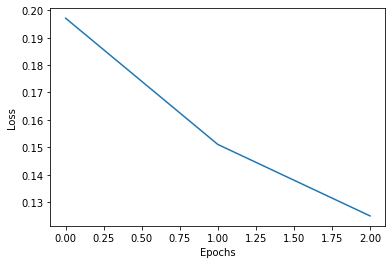

In [40]:
plt.xlabel('Epochs') # Etiqueta del eje x
plt.ylabel('Loss') # Etiqueta del eje y
plt.plot(history.history['loss'], label='Training Loss') # Graficar el loss de entrenamiento

In [41]:
img = tf.keras.preprocessing.image.load_img('data/PetImages/Dog/6778.jpg', target_size=(128, 128)) # Cargar una imagen

img_array = tf.keras.preprocessing.image.img_to_array(img) # Convertir la imagen a un array
img_array = tf.expand_dims(img_array, 0) # Añadir una dimension

predictions = model.predict(img_array) # Predecir la imagen
score = predictions[0] # Obtener el score

print('Esta imagen es %.2f porciento gato y %.2f porciento perro' % (100 - score[0] * 100, score[0] * 100)) # Imprimir el score

Esta imagen es 0.00 porciento gato y 100.00 porciento perro


(-0.5, 127.5, 127.5, -0.5)

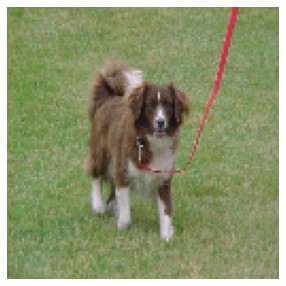

In [42]:
# mostrar la imagen
plt.figure(figsize=(5, 5)) # Crear una figura de 10x10
plt.imshow(img) # Mostrar la imagen
plt.axis('off') # Eliminar los ejes
